In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import WeightedRandomSampler
from tqdm import tqdm

tqdm.pandas()

from triagerx.dataset.processor import DatasetProcessor
from triagerx.model.lbt_p import LBTPClassifier
from triagerx.model.roberta_cnn import RobertaCNNClassifier
from triagerx.model.roberta_fcn import RobertaFCNClassifier
from triagerx.trainer.model_trainer import ModelTrainer
from triagerx.trainer.train_config import TrainConfig


/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/deeptriage/gc_20_topics_kmeans.csv"

df = pd.read_csv(dataset_path)
df = df[df["owner"].notna()]

def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', regex=True)
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df["text"] = df.progress_apply(
            lambda x: "Title: "
            + str(x["issue_title"])
            + "\nDescription: "
            + str(x["description"]),
            axis=1,
        )
    
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    # df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

df = prepare_dataframe(df)
df = clean_data(df)

num_issues = len(df)

print(f"Total number of issues: {num_issues}")

100%|██████████| 109977/109977 [00:00<00:00, 122128.42it/s]


Total number of issues: 109977


In [3]:
lenx = df["text"].str.split().apply(lambda x: len(x))

<Axes: >

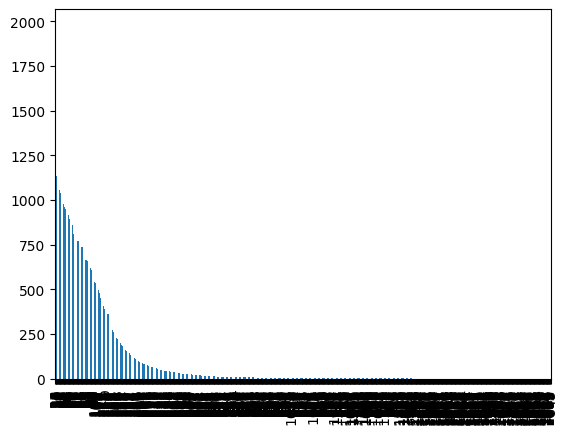

In [4]:
lenx.value_counts().plot(kind="bar")

In [5]:
df["topic_hot"] = pd.get_dummies(df["topic_label"]).values.tolist()

In [6]:
num_cv = 10
sample_threshold=20
samples_per_block = len(df) // num_cv + 1
print(f"Samples per block: {samples_per_block}")

block = 1
sliced_df = df[: samples_per_block * (block+1)]

Samples per block: 10998


In [7]:
# from sentence_transformers import SentenceTransformer

# # Pre-calculate embeddings
# embedding_model = SentenceTransformer("BAAI/bge-small-en")
# embeddings = embedding_model.encode(sliced_df.issue_title.to_list(), show_progress_bar=True)

In [8]:
# from bertopic import BERTopic
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer_model = CountVectorizer(stop_words="english")

# topic_model = BERTopic(calculate_probabilities=True)

In [9]:
# topics, probs = topic_model.fit_transform(sliced_df.issue_title.to_list())

In [10]:
# topic_distr, _ = topic_model.approximate_distribution(sliced_df.issue_title.to_list())

In [11]:
# topic_model.visualize_distribution(topic_distr[1])

In [12]:
# topic_distr, _ = topic_model.approximate_distribution(sliced_df.issue_title.to_list())

In [13]:
# len(probs[0])

In [14]:
# sliced_df["representations"] = list(probs)

X_df = sliced_df[:samples_per_block*block]
y_df = sliced_df[samples_per_block*block : samples_per_block * (block+1)]

developers = X_df["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
X_df = X_df[X_df["owner"].isin(filtered_developers)]

# train_developers = X_df.owner.unique()
# topic_owner = X_df.groupby("owner")["topic_label"].value_counts()
# topic_owner = topic_owner[topic_owner > 5]
# X_df = X_df[X_df.apply(lambda x: (x['owner'], x['topic_label']) in topic_owner.index, axis=1)]

train_owners = set(X_df["owner"])
test_owners = set(y_df["owner"])

unwanted = list(test_owners - train_owners)

y_df = y_df[~y_df["owner"].isin(unwanted)]

print(f"Training data: {len(X_df)}, Validation data: {len(y_df)}")
print(f"Number of developers: {len(X_df.owner.unique())}")

Training data: 7030, Validation data: 6096
Number of developers: 168


In [15]:
lbl2idx = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx

In [16]:
X_df["owner_id"] = X_df["owner"].apply(lambda owner: lbl2idx[owner])
y_df["owner_id"] = y_df["owner"].apply(lambda owner: lbl2idx[owner])

<Axes: >

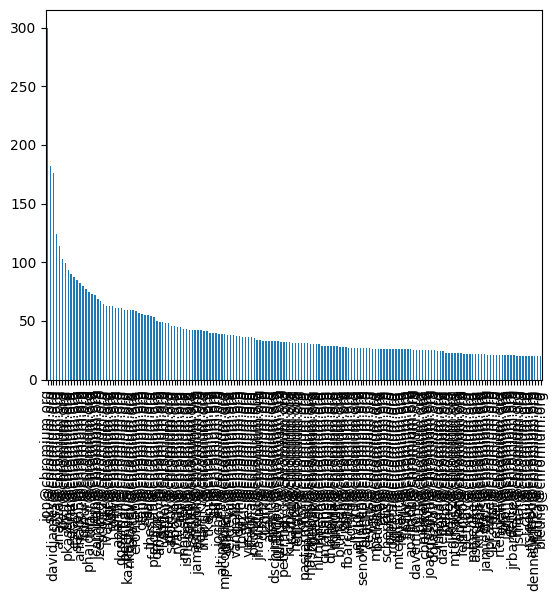

In [17]:
X_df.owner.value_counts().plot(kind="bar")

In [18]:
from sentence_transformers import SentenceTransformer

In [19]:
import pandas as pd
import numpy as np
from loguru import logger
from torch.utils.data import Dataset

from transformers import PreTrainedTokenizer


class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        feature: str = "text",
        target: str = "owner_id",
    ):
        logger.debug("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        # self.embedding_model = SentenceTransformer("BAAI/bge-small-en")
        logger.debug("Tokenizing texts...")
        self.texts = [
            (row.text, self.tokenizer(
                row.text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            ), torch.tensor(row.topic_hot))
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [20]:
import torch
import torch.nn.functional as F
from torch import nn
from transformers import AutoModel, AutoTokenizer


class LBTPClassifierTopic(nn.Module):
    def __init__(
        self, output_size, topic_size, unfrozen_layers=4, embed_size=1024, dropout=0.1
    ) -> None:
        super().__init__()
        model_name = "microsoft/deberta-large"
        self.base_model = AutoModel.from_pretrained(
            model_name, output_hidden_states=True
        )
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Freeze embedding layers
        for p in self.base_model.embeddings.parameters():
            p.requires_grad = False

        # Freeze encoder layers till last {unfrozen_layers} layers
        for i in range(0, 24 - unfrozen_layers):
            for p in self.base_model.encoder.layer[i].parameters():
                p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = 256
        self._max_tokens = 512
        self._embed_size = embed_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, embed_size)),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.classifiers = nn.ModuleList(
            [
                nn.Linear(
                    len(filter_sizes) * self._num_filters + topic_size, output_size
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, tok_type, topic_id):
        outputs = []

        base_out = self.base_model(input_ids=input_ids, token_type_ids=tok_type, attention_mask=attention_mask)
        # pooler_out = base_out.last_hidden_state.squeeze(0)
        hidden_states = base_out.hidden_states[-self.unfrozen_layers :]

        for i in range(self.unfrozen_layers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]
            x = torch.cat(x, dim=1)
            # print(x.shape, pooler_out.shape)
            # x = torch.cat([pooler_out, x], dim=1)
            x = self.dropout(x)
            x = torch.cat([x, topic_id], dim=1)
            x = self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self) -> AutoTokenizer:
        return self._tokenizer


In [21]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            focal_loss = focal_loss * self.alpha

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [22]:
class CombineLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self._ce = nn.CrossEntropyLoss()

    def forward(
        self,
        prediction,
        labels
    ) -> torch.Tensor:
        loss = 0

        for i in range(len(prediction)):
            loss += self._ce(prediction[i], labels)
            # print(loss)

        return loss

In [23]:
class CombineFocalLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self._ce = FocalLoss()

    def forward(
        self,
        prediction,
        labels
    ) -> torch.Tensor:
        loss = 0

        for i in range(len(prediction)):
            loss += self._ce(prediction[i], labels)
            # print(loss)

        return loss

In [24]:
from torch.optim import AdamW

In [25]:
from transformers import get_linear_schedule_with_warmup

In [26]:
class_counts = np.bincount(X_df["owner_id"])
num_samples = sum(class_counts)
labels = X_df["owner_id"].to_list() #corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

learning_rate = 1e-5
epochs = 12
batch_size = 15

model = LBTPClassifierTopic(len(X_df.owner_id.unique()), 20, dropout=0.3)
criterion = CombineFocalLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.1, threshold=1e-8)
# scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=2, )

In [27]:
train = TriageDataset(X_df, model.tokenizer())
val = TriageDataset(y_df, model.tokenizer())

2024-03-01 15:44:17.162 | DEBUG    | __main__:__init__:17 - Generating torch dataset...
2024-03-01 15:44:17.164 | DEBUG    | __main__:__init__:21 - Tokenizing texts...
2024-03-01 15:44:23.789 | DEBUG    | __main__:__init__:17 - Generating torch dataset...
2024-03-01 15:44:23.791 | DEBUG    | __main__:__init__:21 - Tokenizing texts...


In [28]:
from torch.utils.data import DataLoader

In [29]:
train_dataloader = DataLoader(
    dataset=train,
    batch_size=10,
    shuffle=False if sampler else True,
    sampler=sampler,
)
val_dataloader = DataLoader(val, batch_size=10)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_loss = float("inf")

if torch.cuda.is_available():
    logger.debug(f"Selected compute device: {device}")
    model = model.cuda()
    criterion = criterion.cuda()

2024-03-01 15:44:29.615 | DEBUG    | __main__:<module>:5 - Selected compute device: cuda


In [31]:
from sklearn.metrics import precision_recall_fscore_support

In [32]:
def log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        train_data,
        validation_data,
        topk,
    ):
        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                    | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                    | Val Loss: {total_loss_val / len(validation_data): .3f} \
                    | Val Accuracy: {total_acc_val / len(validation_data): .3f} \
                    | Top 10: {topk} \
                    | Precision: {precision: .3f} \
                    | Recall: {recall: .3f} \
                    | F1-score: {f1_score: .3f}"

        logger.info(log)

In [33]:
from tqdm import tqdm

In [34]:
model = model.cuda()

In [35]:
for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader):
        # print(train_input)
        train_label = train_label.to(device)
        mask = train_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = train_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = train_input[1]["token_type_ids"].squeeze(1).to(device)
        repr = train_input[2].to(device)
        # print(tok_type.shape, input_id.shape, mask.shape)
        # print(repr.dtype, input_id.dtype, mask.dtype)

        output = model(input_id, mask, tok_type, repr)

        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()

        output = torch.sum(torch.stack(output), 0)
        acc = (output.argmax(dim=1) == train_label).sum().item()
        
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_acc_val = 0
    total_loss_val = 0
    correct_top_k = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for val_input, val_label in val_dataloader:
            val_label = val_label.to(device)
            mask = val_input[1]["attention_mask"].squeeze(1).to(device)
            input_id = val_input[1]["input_ids"].squeeze(1).to(device)
            tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)
            repr = val_input[2].to(device)

            output = model(input_id, mask, tok_type, repr)

            batch_loss = criterion(output, val_label.long())
            total_loss_val += batch_loss.item()

            output = torch.sum(torch.stack(output), 0)
            _, top_k_predictions = output.topk(10, 1, True, True)

            top_k_predictions = top_k_predictions.t()

            correct_top_k += (
                top_k_predictions.eq(
                    val_label.view(1, -1).expand_as(top_k_predictions)
                )
                .sum()
                .item()
            )

            acc = (output.argmax(dim=1) == val_label).sum().item()

            all_preds.append(output.argmax(dim=1).cpu().numpy())
            all_labels.append(val_label.cpu().numpy())

            total_acc_val += acc

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro"
    )

    top10 = correct_top_k / len(y_df)

    log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        X_df,
        y_df,
        top10,
    )

    val_loss = total_loss_val / len(y_df)

    if scheduler:
        scheduler.step(val_loss)

    if val_loss < best_loss:
        logger.success("Found new best model. Saving weights...")
        torch.save(model.state_dict(), "ensemble_deberta_cv1.pt")
        best_loss = val_loss

  0%|          | 0/703 [00:00<?, ?it/s]

 88%|████████▊ | 622/703 [09:28<01:13,  1.09it/s]


KeyboardInterrupt: 

In [ ]:
!nvidia-smi

Thu Feb 22 23:55:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   64C    P0              78W / 250W |  32409MiB / 40960MiB |     97%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
model.load_state_dict(torch.load("/home/mdafifal.mamun/notebooks/triagerX/ensemble_deberta_cv1.pt"))

<All keys matched successfully>

In [ ]:
loader = DataLoader(val, 30)

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [ ]:
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
all_embeddings = similarity_model.encode(X_df.issue_title.to_list(), batch_size=15)

In [ ]:
def get_top_k_similar_devs(issues, k=5, threshold=0.65):
    test_embed = similarity_model.encode(issues)
    cos = util.cos_sim(test_embed, all_embeddings)
    topk_values, topk_indices = torch.topk(cos, k=k)
    
    similarities = []
    
    for idx, sim_score in zip(topk_indices, topk_values):
        sim_threshold = sim_score >= threshold
        filtered_idx = idx[sim_threshold].numpy()
        similarities.append(X_df.iloc[filtered_idx]["owner_id"].unique().tolist())

    return similarities

In [ ]:
total_acc_val = 0
total_loss_val = 0
correct_top_k = 0
correct_top_k_wo_sim = 0

all_preds = []
all_labels = []
device="cuda"

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = val_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)
        repr = torch.tensor(val_input[2]).to(device)

        output = model(input_id, mask, tok_type, repr)



        output = torch.sum(torch.stack(output), 0)

        #wo similarity
        _, top_k_wo_sim = output.topk(10, 1, True, True)

        top_k_wo_sim = top_k_wo_sim.t()

        correct_top_k_wo_sim += (
            top_k_wo_sim.eq(
                val_label.view(1, -1).expand_as(top_k_wo_sim)
            )
            .sum()
            .item()
        )


        # with similarity
        _, top_k_predictions = output.topk(10, 1, True, True)
        similar_preds = get_top_k_similar_devs(val_input[0], k=5)

        unique_preds = []

        for top, sim in zip(top_k_predictions, similar_preds):
            # print(top, sim)
            
            copy_pred = top.cpu().numpy().tolist()
            top_preds = top.cpu().numpy().tolist()[:5]

            for s in sim:
                if s not in top_preds:
                    top_preds.append(s)
            
            if len(top_preds) < 10:
                top_preds = top_preds + copy_pred[5:5 + 10 - len(top_preds)]
            
            unique_preds.append(top_preds)

        unique_preds = torch.tensor(unique_preds).cuda()
        top_k_predictions = unique_preds.t()

        correct_top_k += (
            top_k_predictions.eq(
                val_label.view(1, -1).expand_as(top_k_predictions)
            )
            .sum()
            .item()
        )

        # break

        acc = (output.argmax(dim=1) == val_label).sum().item()

        all_preds.append(output.argmax(dim=1).cpu().numpy())
        all_labels.append(val_label.cpu().numpy())

        total_acc_val += acc

/tmp/ipykernel_3821156/2502538685.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  repr = torch.tensor(val_input[2]).to(device)


In [ ]:
print(f"Correct Prediction without Similarity: {correct_top_k_wo_sim}, {correct_top_k_wo_sim / len(y_df)}")
print(f"Correct Prediction with Similarity: {correct_top_k}, {correct_top_k / len(y_df)}")

Correct Prediction without Similarity: 4315, 0.7078412073490814
Correct Prediction with Similarity: 4326, 0.7096456692913385


Block 1
===================================================================
Correct Prediction without Similarity: 4347, 0.7130905511811023

Correct Prediction with Similarity: 4342, 0.7122703412073491


Block 9
==============
#### Threshold: None
---
Correct Prediction without Similarity: 7607, 0.7057240931440765

Correct Prediction with Similarity: 7598, 0.7048891362835142

#### Threshold: 0.63
---
Correct Prediction without Similarity: 7598, 0.7048891362835142

Correct Prediction with Similarity: 7669, 0.7114760181835049

In [ ]:
all_preds_np = np.concatenate(all_preds)
all_labels_np = np.concatenate(all_labels)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
idx2label = {
    row["owner_id"]: row["owner"]
    for _, row in y_df.iterrows()
}

labels = y_df.owner_id.to_list()
labels = sorted(set(labels))
labels = [f"{idx}: {idx2label[idx]}" for idx in labels]

In [ ]:
confusion_matrix(all_labels_np, all_preds_np)

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  6,  0, ...,  0,  0,  1],
       [ 0,  0, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  3,  0,  0],
       [ 0,  0,  0, ...,  0, 15,  0],
       [ 0,  0,  0, ...,  0,  0,  5]])

In [ ]:
y_df[y_df.owner == "altimofeev@chromium.org"].topic_label.value_counts()

Chrome sync issues                        3
Performance testing issues in Chromium    1
Name: topic_label, dtype: int64

In [ ]:
X_df[X_df.owner == "altimofeev@chromium.org"].topic_label.value_counts()

Shill WiFi configuration                 13
Chrome sync issues                        8
Security and SSL issues                   7
Chrome Tab and Window Behavior Issues     4
Webpage rendering regression issues       1
Data Enhancement                          1
Input and keyboard issues                 1
DevTools Crashes                          1
Chrome stability issues                   1
Chrome crash reports                      1
Layout Testing Issues                     1
Name: topic_label, dtype: int64

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(all_labels_np, all_preds_np, target_names=labels))

                                precision    recall  f1-score   support

          0: a...@chromium.org       0.03      0.02      0.02        61
            1: aa@chromium.org       0.10      0.12      0.11        50
        2: abarth@chromium.org       0.19      0.21      0.20        48
       3: achuith@chromium.org       0.12      0.20      0.15        10
          4: adlr@chromium.org       0.68      0.80      0.73        98
           5: agl@chromium.org       0.11      0.18      0.14        56
        6: akalin@chromium.org       0.18      0.15      0.16        20
    7: altimofeev@chromium.org       0.00      0.00      0.00         4
          8: amit@chromium.org       0.29      0.57      0.38         7
        9: ananta@chromium.org       0.32      0.25      0.28        56
      10: annapop@chromium.org       0.50      0.67      0.57        48
     11: apatrick@chromium.org       0.47      0.33      0.39        21
      12: apavlov@chromium.org       0.43      0.49      0.46  

In [ ]:
def get_topic_distribution(owner):
    print("Training topic distribution")
    print("=======================================")
    print(X_df[X_df.owner == owner].topic_label.value_counts())

    print("\n\nTesting topic distribution")
    print("=======================================")
    print(y_df[y_df.owner == owner].topic_label.value_counts())

In [ ]:
X_df.topic_label.value_counts()

Chrome Tab and Window Behavior Issues     947
Build failures                            840
Chrome stability issues                   487
Layout Testing Issues                     400
Chrome crash reports                      391
Security and SSL issues                   372
Input and keyboard issues                 370
Webpage rendering regression issues       357
Chrome sync issues                        354
Shill WiFi configuration                  337
iOS File Issues                           321
Data Enhancement                          298
Touch and Scroll Issues                   273
DevTools Crashes                          260
GPU rendering issues                      235
Memory Leaks in WebCore and Blink         220
Performance testing issues in Chromium    197
WebRTC audio/video issues                 184
Bookmark issues                           174
Performance Regression in Blink            13
Name: topic_label, dtype: int64

In [ ]:
get_topic_distribution("a...@chromium.org")

Training topic distribution
Chrome Tab and Window Behavior Issues     10
Webpage rendering regression issues        5
Memory Leaks in WebCore and Blink          4
Chrome stability issues                    4
DevTools Crashes                           3
Data Enhancement                           3
Input and keyboard issues                  3
Touch and Scroll Issues                    2
Bookmark issues                            1
Security and SSL issues                    1
Chrome sync issues                         1
Layout Testing Issues                      1
Build failures                             1
iOS File Issues                            1
Performance testing issues in Chromium     1
Name: topic_label, dtype: int64


Testing topic distribution
Chrome Tab and Window Behavior Issues     17
Webpage rendering regression issues        7
DevTools Crashes                           6
iOS File Issues                            6
Touch and Scroll Issues                    4
Input and k

In [ ]:
get_topic_distribution("sky@chromium.org")

Training topic distribution
Chrome Tab and Window Behavior Issues     62
Bookmark issues                           45
Chrome crash reports                      19
Input and keyboard issues                 13
Chrome stability issues                    8
Layout Testing Issues                      8
Webpage rendering regression issues        6
GPU rendering issues                       4
Touch and Scroll Issues                    4
DevTools Crashes                           3
Security and SSL issues                    2
Chrome sync issues                         2
iOS File Issues                            2
Memory Leaks in WebCore and Blink          1
Shill WiFi configuration                   1
Data Enhancement                           1
Performance testing issues in Chromium     1
Name: topic_label, dtype: int64


Testing topic distribution
Chrome Tab and Window Behavior Issues    37
Bookmark issues                          22
Chrome crash reports                     14
Input and keyb